# Building a preliminary spectrum.  

* Add instruction here or in readme for how to set up your own analysis pipeline.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from pathlib import Path

# Jupyter Lab imports.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Path to local imports.
sys.path.append("/home/drew/He6CRES/rocks_analysis_pipeline/")
from results import ExperimentResults
from rocks_utility import he6cres_db_query

# Path to local imports.
sys.path.append("/home/drew/He6CRES/he6-cres-spec-sims/")

# Local imports.
import he6_cres_spec_sims.spec_tools.spec_calc.spec_calc as sc
import he6_cres_spec_sims.experiment as exp

### 1a: Grab the experiment directory and root files for both he and ne. 

In [3]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
experiment_name = "he6_full_0"
analysis_id = 1
include_root_files = True
max_root_files_to_grab = 5
rebuild_experiment_dir = False

In [4]:
he = ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = analysis_id, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )

Keeping existing experiment directory.


All 265 root files are already present here: /media/drew/T7 Shield/rocks_analysis/saved_experiments/he6_full_0_aid_1/root_files


In [5]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
experiment_name = "ne19_full_0"
analysis_id = 2
include_root_files = True
max_root_files_to_grab = 5
rebuild_experiment_dir = False

In [6]:
ne = ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = analysis_id, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )

Keeping existing experiment directory.


All 285 root files are already present here: /media/drew/T7 Shield/rocks_analysis/saved_experiments/ne19_full_0_aid_2/root_files


## 2. Define functions to build a spectrum. 

In [7]:
def build_spectrum(events, root_files, cuts = {"EventMeanSNR": .5, "EventStartFreq": 150e6}): 
    
    cols = list
    
    # Changing this to be an absolute cut not a relative one. 12/15/22
    condition = ((events["EventMeanSNR"] > cuts["EventMeanSNR"]) 
                 & (events["EventStartFreq"] > cuts["EventStartFreq"]))
    
    # print(f"fraction of spectrum remaining post cut: {condition.mean()}")
    valid_events = events[condition]
    
    condition = (root_files.root_file_exists ==True)
    normalize_df = root_files[condition].groupby(["run_id", "file_id"])[["monitor_rate", "set_field"]].first().reset_index()

    event_counts = valid_events.groupby(["run_id", "file_id"]).EventID.count().to_frame("event_count").reset_index()
    
    spec1 = pd.merge(normalize_df, event_counts, how = "left", left_on = ["run_id", "file_id"], right_on = ["run_id", "file_id"])
    spec1 = spec1.fillna(0)
    # display(spec1.head())
    
    spec2 = spec1.groupby(["set_field"])[["event_count", "monitor_rate"]].sum().reset_index()
    
    spec2 = spec2.rename(columns={'monitor_rate':'tot_monitor_rate'})
    
    spec3 = spec1.groupby(["set_field"]).event_count.count().to_frame("seconds_of_data").reset_index()
    spec4 = pd.merge(spec2, spec3, how = "inner", left_on = ["set_field"], right_on = ["set_field"])
    
    spec4["normed_tot_monitor_rate"] = spec4["tot_monitor_rate"] / spec4["tot_monitor_rate"].mean()
    
    spec4["mon_adjusted_count"] = spec4["event_count"]/spec4["normed_tot_monitor_rate"]
    spec4["mon_adjusted_count_uncert"] =  spec4["mon_adjusted_count"]**.5
    
    # display(spec4.head(12))
    
    return spec4


In [8]:
def plot_spectrum(spectrum_df, ax, label, norm = False, color = 'tab:blue' ): 
    
    x = spectrum_df["set_field"]
    y_mean = spectrum_df["mon_adjusted_count"]
    error = 0.5*spectrum_df["mon_adjusted_count_uncert"]
    
    if norm: 
        y_mean = y_mean / spectrum_df["mon_adjusted_count"].mean()
        error = error / spectrum_df["mon_adjusted_count"].mean()
        
    lower = y_mean - error
    upper = y_mean + error

    # Draw plot with error band and extra formatting to match seaborn style
    ax.plot(x, y_mean, label= label, color = color, marker='.', markersize = 15, ls = '' )
    ax.plot(x, lower, color=color, alpha=0.1)
    ax.plot(x, upper, color=color, alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.2)
    
    ax.set_ylabel('monitor adjusted counts')
    if norm: 
        ax.set_ylabel('relative rate')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return None



## 3. Make an interactive display of the spectra 

Notes: 

* He: 377, 388, 381 had currupt files. 
* Ne: 522 the track/event reconstruction didn't work despite there being tracks present. 

In [9]:
he.root_files = he.root_files[~he.root_files.run_id.isin([377,380, 381])]
he.events = he.events[~he.events.run_id.isin([377,380, 381])]

ne.root_files = ne.root_files[~ne.root_files.run_id.isin([522])]
ne.events = ne.events[~ne.events.run_id.isin([522])]

In [10]:
ne.events.columns

Index(['run_id', 'file_id', 'EventID', 'EventStartTime', 'EventEndTime',
       'EventStartFreq', 'EventEndFreq', 'EventTimeLength', 'EventFreqLength',
       'EventTrackCoverage', 'EventMeanSNR', 'EventSlope', 'EventNBins',
       'EventTrackTot', 'EventFreqIntc', 'EventTimeIntc', 'field', 'set_field',
       'monitor_rate'],
      dtype='object')

In [11]:
%matplotlib widget

set_fields = sorted(he.events['set_field'].unique().tolist())

plt.rcParams['figure.dpi']= 100
@interact
def scatter_plots(
    EventMeanSNR = widgets.FloatSlider(value=.4, min=0,max=1.0,step=1e-2, description = "EventMeanSNR"),
    EventStartFreq = widgets.FloatSlider(value=175, min=0,max=1200,step=1, description = "EventStartFreq (MHz)"),
    show_he = widgets.Checkbox(
    value=True,
    description='show_6he',
    disabled=False,
    indent=False
),
    show_ne = widgets.Checkbox(
    value=True,
    description='show_19ne',
    disabled=False,
    indent=False
),
    norm = widgets.Checkbox(
    value=False,
    description='norm',
    disabled=False,
    indent=False
)
):
    plt.close("all")
    # print("\nHe:\n")
    he_spectrum = build_spectrum(he.events, he.root_files, cuts = {"EventMeanSNR": EventMeanSNR, "EventStartFreq": EventStartFreq*1e6})
    # print("\nNe:\n")
    ne_spectrum = build_spectrum(ne.events, ne.root_files, cuts = {"EventMeanSNR": EventMeanSNR, "EventStartFreq": EventStartFreq*1e6})
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    if show_he: 
        plot_spectrum(he_spectrum,ax, label = "6he",   norm = norm, color = 'tab:blue')
    if show_ne:
        plot_spectrum(ne_spectrum,ax, label = "19ne",  norm = norm, color = 'tab:red')
    
    ax.set_title("Preliminary Spectrum")
    ax.legend()

    plt.show()
    
    # print("\nHe:\n")
    # display(he_spectrum) 
    # print("\nNe:\n")
    # display(ne_spectrum) 
    

interactive(children=(FloatSlider(value=0.4, description='EventMeanSNR', max=1.0, step=0.01), FloatSlider(valu…

## Comparing the above to MC. 

# Load MC runs to compare to data. 

In [12]:
ne_experiment_config_path = "/media/drew/T7 Shield/spec_sims_results/experiments/ne_10062022/ne_10062022_exp.yaml"
ne_sim = exp.ExpResults.load(experiment_config_path = ne_experiment_config_path, include_sampled_gammas= False)

/media/drew/T7 Shield/spec_sims_results/experiments/ne_10062022
+++++++++++++++++++++++++++++++++++++++++++++++++


Loading simulation 0 / 11


+++++++++++++++++++++++++++++++++++++++++++++++++
Optimization terminated successfully.
         Current function value: -0.750840
         Iterations: 43
         Function evaluations: 95
Trap width: (-0.04319392015039922,0.04319392015039922)
Maximum Field: 0.7508396820186829

Set field: 0.75, Trap current: 0.4153845

+++++++++++++++++++++++++++++++++++++++++++++++++


Loading simulation 1 / 11


+++++++++++++++++++++++++++++++++++++++++++++++++
Optimization terminated successfully.
         Current function value: -1.001120
         Iterations: 43
         Function evaluations: 97
Trap width: (-0.04319392395019532,0.04319392395019532)
Maximum Field: 1.0011195760249108

Set field: 1.0, Trap current: 0.553846

+++++++++++++++++++++++++++++++++++++++++++++++++


Loading simulation 2 / 11


+++++++++++++++++++++++++++++++++++++++++++++++++
Optimi

In [13]:
he_experiment_config_path = "/media/drew/T7 Shield/spec_sims_results/experiments/he_08182022/he_08182022_exp.yaml"
he_sim = exp.ExpResults.load(experiment_config_path = he_experiment_config_path, include_sampled_gammas= False)

/media/drew/T7 Shield/spec_sims_results/experiments/he_08182022
+++++++++++++++++++++++++++++++++++++++++++++++++


Loading simulation 0 / 11


+++++++++++++++++++++++++++++++++++++++++++++++++
Optimization terminated successfully.
         Current function value: -3.253639
         Iterations: 43
         Function evaluations: 96
Trap width: (-0.04319391632080079,0.04319391632080079)
Maximum Field: 3.2536386230916876

Set field: 3.25, Trap current: 1.8

+++++++++++++++++++++++++++++++++++++++++++++++++


Loading simulation 1 / 11


+++++++++++++++++++++++++++++++++++++++++++++++++
Optimization terminated successfully.
         Current function value: -3.003359
         Iterations: 43
         Function evaluations: 95
Trap width: (-0.04319392015039922,0.04319392015039922)
Maximum Field: 3.0033587280747316

Set field: 3.0, Trap current: 1.661538

+++++++++++++++++++++++++++++++++++++++++++++++++


Loading simulation 2 / 11


+++++++++++++++++++++++++++++++++++++++++++++++++
Optimization

In [14]:

def post_cut_sim(events_ne_sim,events_he_sim, snr_cut):
    
    power_max_sim_ne = events_ne_sim.band_power.max()
    power_max_sim_he = events_he_sim.band_power.max()

    cut_condition_sim_ne = (events_ne_sim.band_power > power_max_sim_ne*snr_cut)
    cut_condition_sim_he = (events_he_sim.band_power > power_max_sim_he*snr_cut)

    post_cut_counts_ne = events_ne_sim[cut_condition_sim_ne].groupby("field").fraction_of_spectrum.count()
    post_cut_counts_he = events_he_sim[cut_condition_sim_he].groupby("field").fraction_of_spectrum.count()
    
    frac_ne = events_ne_sim.groupby("field").fraction_of_spectrum.first()
    frac_he = events_he_sim.groupby("field").fraction_of_spectrum.first()
    
    beta_num_ne = events_ne_sim.groupby("field").beta_num.max()
    beta_num_he = events_he_sim.groupby("field").beta_num.max()
    
    sampled_rate_ne = frac_ne
    sampled_rate_he = frac_he
    
    # post_cut_err_ne = post_cut_counts_ne**.5
    # post_cut_err_he = post_cut_counts_he**.5
    
    post_cut_rate_ne = post_cut_counts_ne * frac_ne / beta_num_ne
    post_cut_rate_he = post_cut_counts_he * frac_he / beta_num_he
    
    post_cut_rate_err_ne = post_cut_counts_ne**.5 * frac_ne / beta_num_ne
    post_cut_rate_err_he = post_cut_counts_he**.5 * frac_he / beta_num_he
    
    post_cut_rate_ne
    fields = frac_ne.index

    sampled_rate_ne /= sampled_rate_ne.mean()
    sampled_rate_he /= sampled_rate_he.mean()
    
    post_cut_rate_ne /= post_cut_rate_ne.mean()
    post_cut_rate_he /= post_cut_rate_he.mean()
    
    return pd.DataFrame({"fields":fields, "sampled_rate_ne":sampled_rate_ne, "sampled_rate_he": sampled_rate_he, "rate_ne": post_cut_rate_ne, "rate_he": post_cut_rate_he,
                        "rate_err_ne": post_cut_rate_err_ne, "rate_err_he": post_cut_rate_err_he})

In [15]:
def plot_spectrum_sim(sim_df, ax, colors = ['tab:blue', 'tab:red'] ): 
    
    x = sim_df["fields"]
    y_mean_ne = sim_df["rate_ne"]
    error_ne = 0.5*sim_df["rate_err_ne"]
    
    lower_ne = y_mean_ne - error_ne
    upper_ne = y_mean_ne + error_ne

    # Draw plot with error band and extra formatting to match seaborn style
    ax.plot(x, y_mean_ne, color = colors[0],  label = "19Ne Monte Carlo")
    ax.plot(x, lower_ne, color=colors[0], alpha=0.1)
    ax.plot(x, upper_ne, color=colors[0], alpha=0.1)
    ax.fill_between(x, lower_ne, upper_ne, alpha=0.1)
    
    y_mean_he = sim_df["rate_he"]
    error_he = 0.5*sim_df["rate_err_he"]
    
    lower_he = y_mean_he - error_he
    upper_he = y_mean_he + error_he

    # Draw plot with error band and extra formatting to match seaborn style
    ax.plot(x, y_mean_he, color = colors[1], label = "6He Monte Carlo")
    ax.plot(x, lower_he, color=colors[1], alpha=0.1)
    ax.plot(x, upper_he, color=colors[1], alpha=0.1)
    ax.fill_between(x, lower_he, upper_he, alpha=0.1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return None

In [16]:
he_sim.__dict__

{'experiment_params': {'experiment_name': 'he_08182022',
  'base_config_path': '/media/drew/T7 Shield/spec_sims_results/experiments/base_config_10202022.yaml',
  'isotope': 'He6',
  'events_to_simulate': -1,
  'betas_to_simulate': 2000.0,
  'rand_seeds': [4062,
   3759,
   3456,
   3153,
   2850,
   2547,
   2244,
   1941,
   1638,
   1335,
   1032],
  'fields_T': [3.25, 3.0, 2.75, 2.5, 2.25, 2.0, 1.75, 1.5, 1.25, 1.0, 0.75],
  'traps_A': [1.8,
   1.661538,
   1.523077,
   1.384615,
   1.246154,
   1.107692,
   0.969231,
   0.830769,
   0.692308,
   0.553846,
   0.4153845]},
 'config_paths': [PosixPath('/media/drew/T7 Shield/spec_sims_results/experiments/he_08182022/0_field_3.25T.yaml'),
  PosixPath('/media/drew/T7 Shield/spec_sims_results/experiments/he_08182022/1_field_3.0T.yaml'),
  PosixPath('/media/drew/T7 Shield/spec_sims_results/experiments/he_08182022/2_field_2.75T.yaml'),
  PosixPath('/media/drew/T7 Shield/spec_sims_results/experiments/he_08182022/3_field_2.5T.yaml'),
  PosixP

In [17]:
events_he_sim = he_sim.tracks
events_ne_sim = ne_sim.tracks

sim_df = post_cut_sim(events_ne_sim,events_he_sim, snr_cut = .4)

display(sim_df.describe())

,fields,sampled_rate_ne,sampled_rate_he,rate_ne,rate_he,rate_err_ne,rate_err_he
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,2.000000,1.000000,1.000000,1.000000,1.000000,0.000486,0.000474
std,0.829156,0.618584,0.616996,0.670852,0.619099,0.000319,0.000296
min,0.750000,0.125747,0.056721,0.000217,0.000095,0.000003,0.000001
25%,1.375000,0.494668,0.485701,0.422621,0.534125,0.000223,0.000242
50%,2.000000,0.985013,1.105896,0.984030,1.121967,0.000481,0.000529
75%,2.625000,1.528921,1.577368,1.589762,1.550793,0.000757,0.000743
max,3.250000,1.777127,1.683659,1.793049,1.660137,0.000873,0.000794


In [18]:
%matplotlib widget

set_fields = sorted(he.events['set_field'].unique().tolist())

plt.rcParams['figure.dpi']= 100
@interact
def scatter_plots(
    EventMeanSNR = widgets.FloatSlider(value=.33, min=0,max=1.0,step=1e-2, description = "EventMeanSNR"),
    EventStartFreq = widgets.FloatSlider(value=300, min=0,max=1200,step=1, description = "EventStartFreq (MHz)"),
    show_he = widgets.Checkbox(
    value=True,
    description='show_6he',
    disabled=False,
    indent=False
),
    show_ne = widgets.Checkbox(
    value=True,
    description='show_19ne',
    disabled=False,
    indent=False
),
    norm = widgets.Checkbox(
    value=True,
    description='norm',
    disabled=False,
    indent=False
)
):
    plt.close("all")
    
    sim_df = post_cut_sim(events_ne_sim,events_he_sim, snr_cut = EventMeanSNR)
    
    
    he_spectrum = build_spectrum(he.events, he.root_files, cuts = {"EventMeanSNR": EventMeanSNR, "EventStartFreq": EventStartFreq*1e6})

    ne_spectrum = build_spectrum(ne.events, ne.root_files, cuts = {"EventMeanSNR": EventMeanSNR, "EventStartFreq": EventStartFreq*1e6})

    
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(figsize=(15,8))
    
    if show_ne:
        plot_spectrum(ne_spectrum,ax, label = "19Ne Data",  norm = norm, color = 'tab:blue')
    if show_he: 
        plot_spectrum(he_spectrum,ax, label = "6He Data",   norm = norm, color = 'tab:red')

    
    plot_spectrum_sim(sim_df, ax, colors = ['tab:blue', 'tab:red'] )
    ax.set_title("Preliminary Spectra")
    ax.set_xlabel('Field (T)')
    ax.legend()
    
    ax.set_ylabel('relative rate')

    plt.show()

    # .34, 300 work well. 

interactive(children=(FloatSlider(value=0.33, description='EventMeanSNR', max=1.0, step=0.01), FloatSlider(val…

In [19]:
he.events.columns

Index(['run_id', 'file_id', 'EventID', 'EventStartTime', 'EventEndTime',
       'EventStartFreq', 'EventEndFreq', 'EventTimeLength', 'EventFreqLength',
       'EventTrackCoverage', 'EventMeanSNR', 'EventSlope', 'EventNBins',
       'EventTrackTot', 'EventFreqIntc', 'EventTimeIntc', 'field', 'set_field',
       'monitor_rate'],
      dtype='object')

## Ratio Plots 12152022

100 10


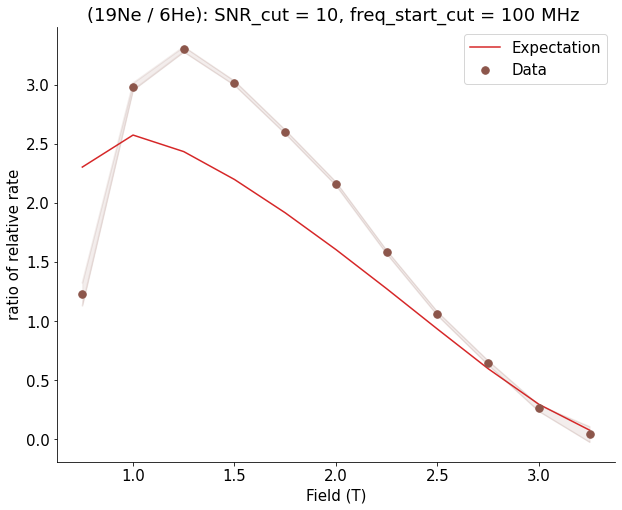

150 10


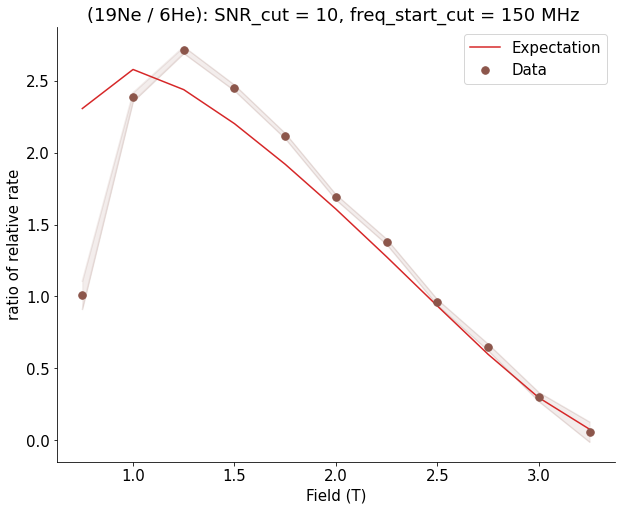

200 10


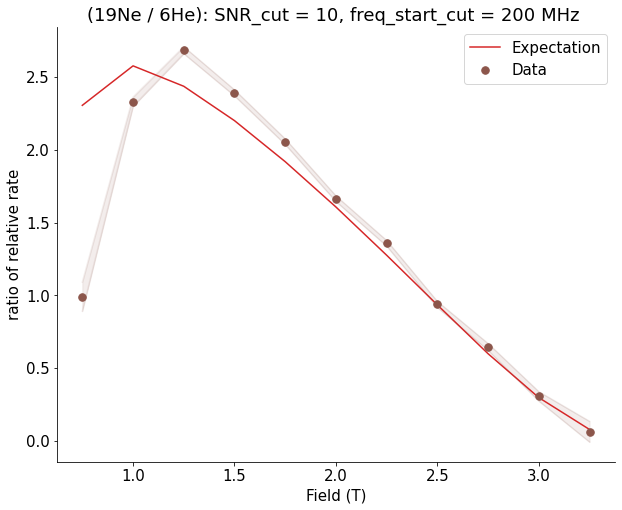

250 10


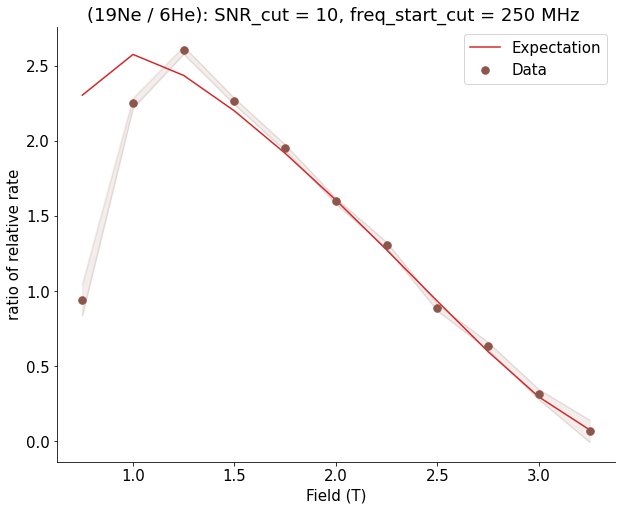

300 10


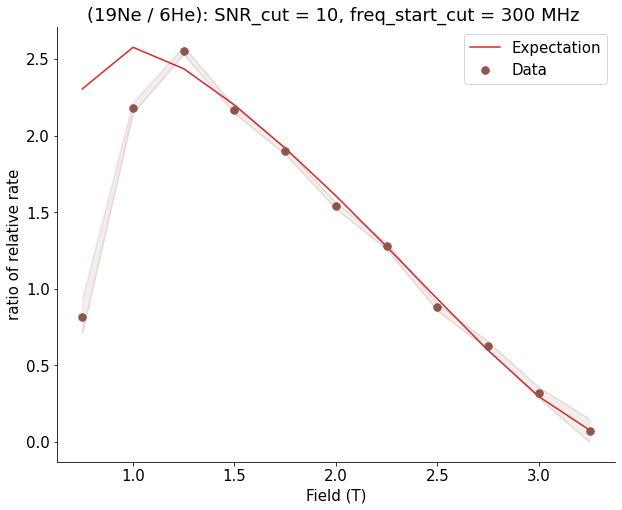

350 10


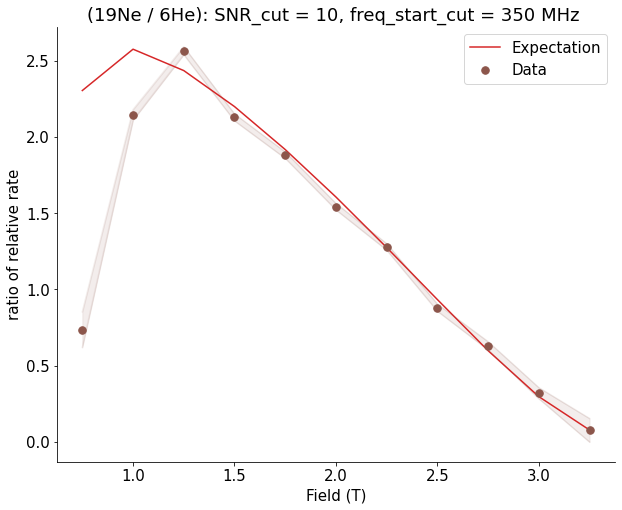

400 10


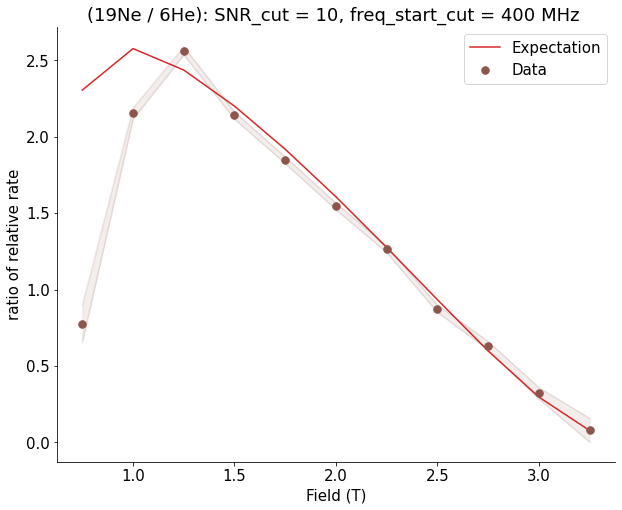

450 10


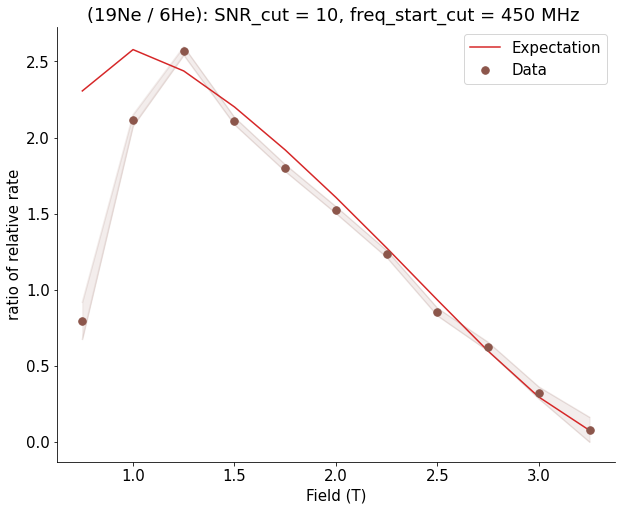

500 10


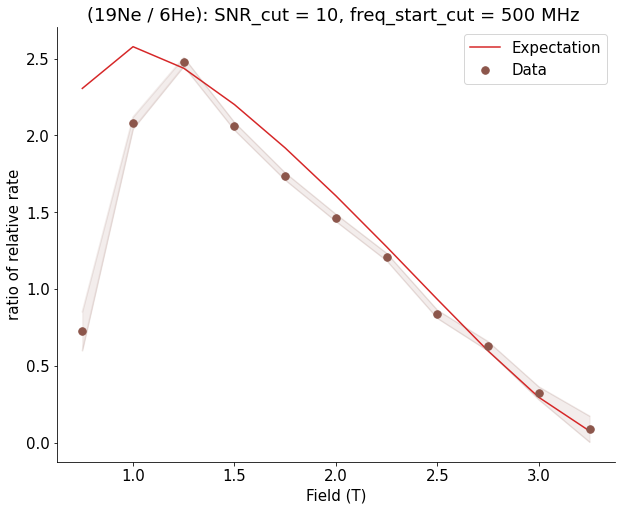

550 10


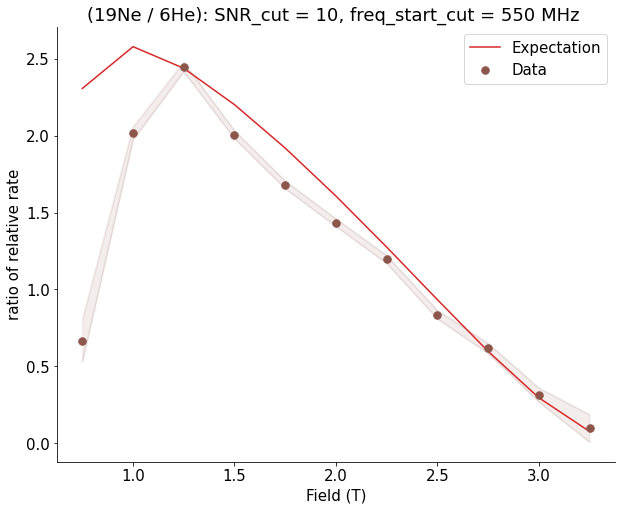

100 12


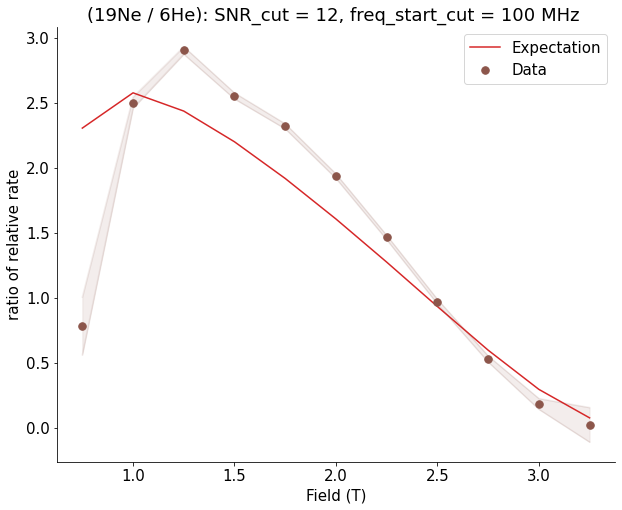

150 12


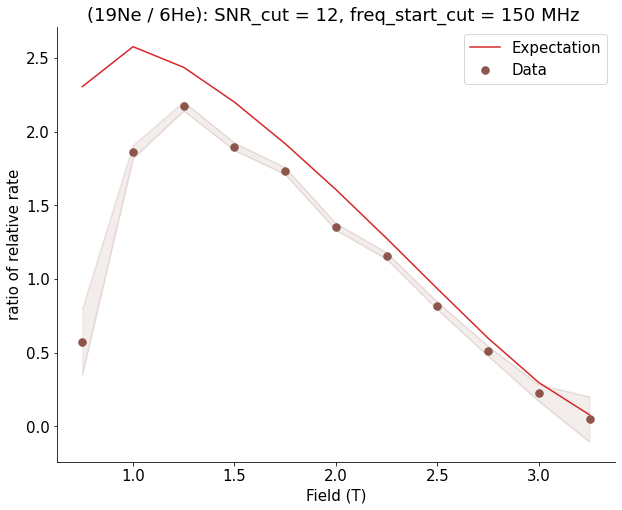

200 12


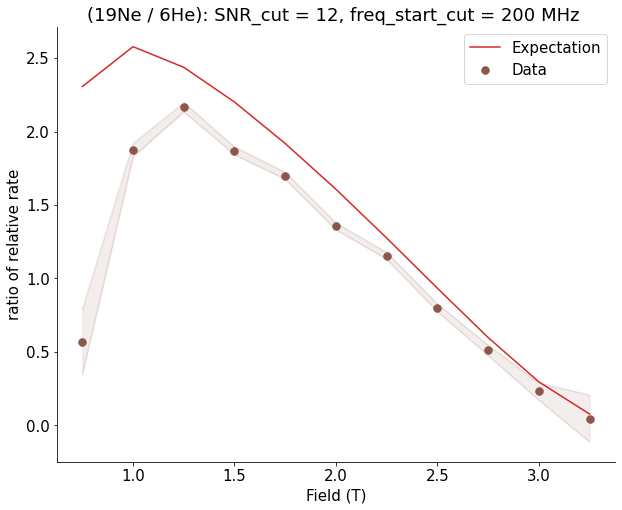

250 12


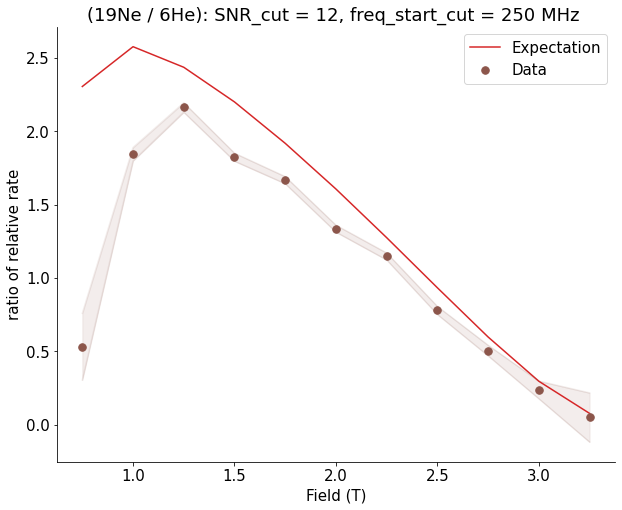

300 12


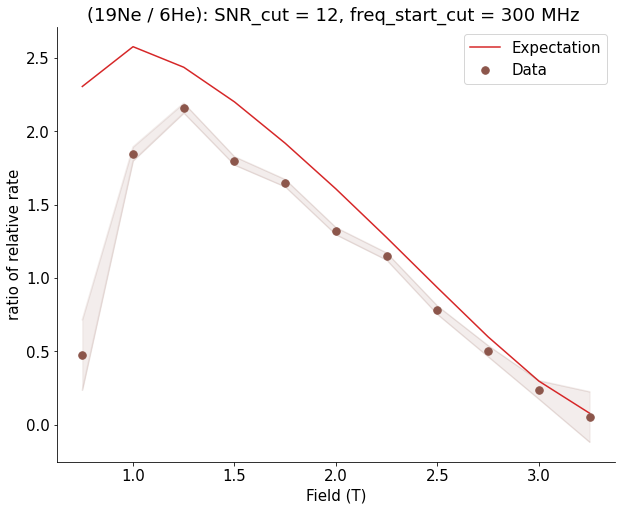

350 12


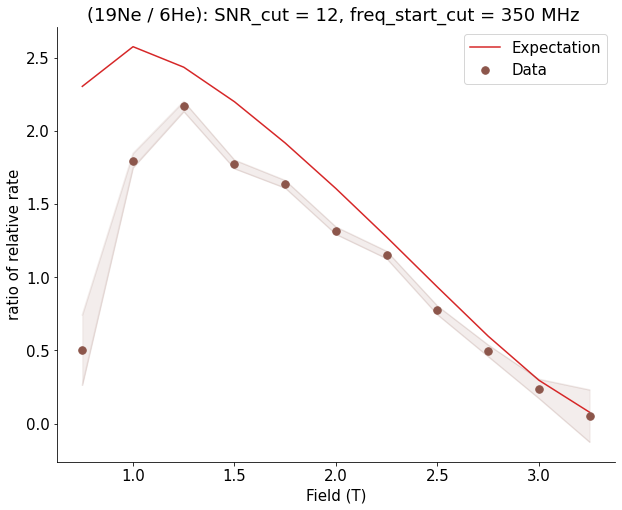

400 12


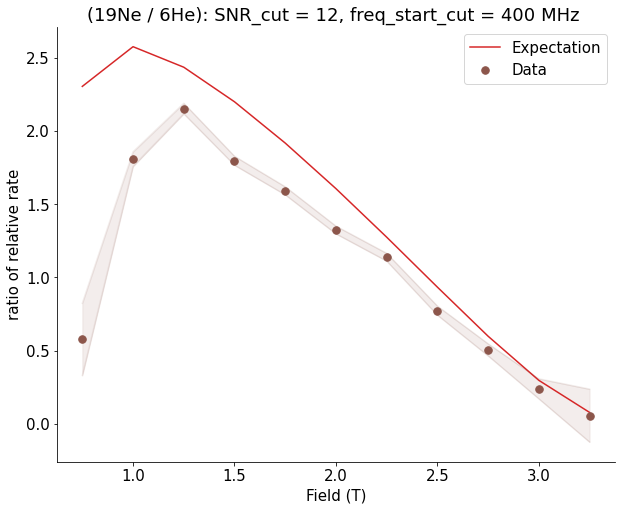

450 12


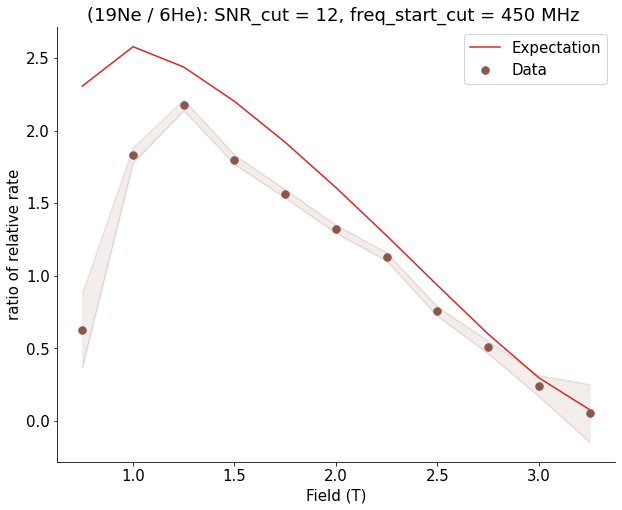

500 12


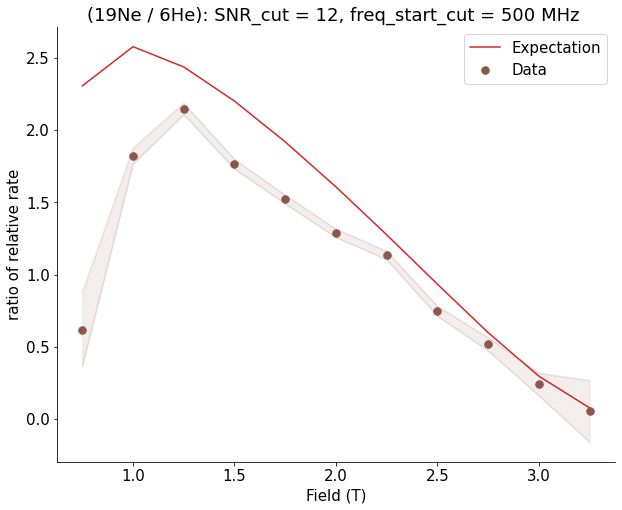

550 12


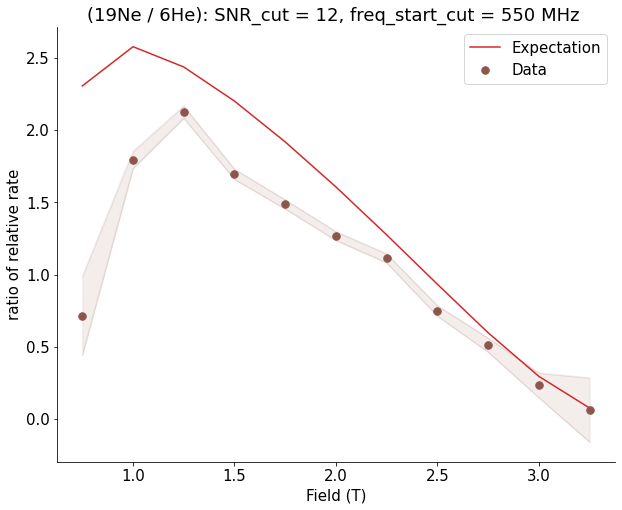

100 14


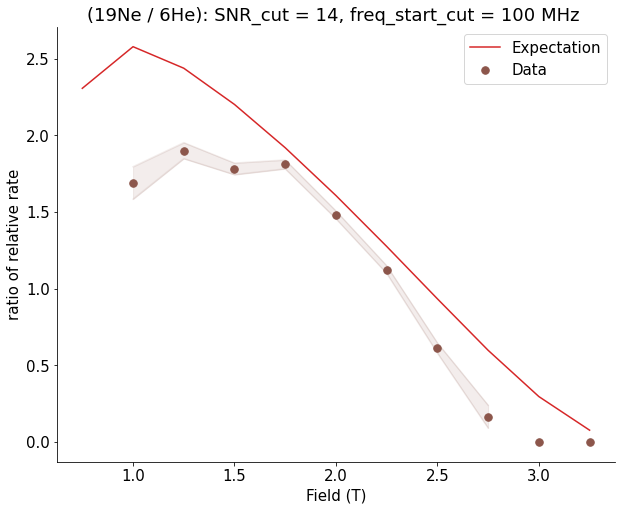

150 14


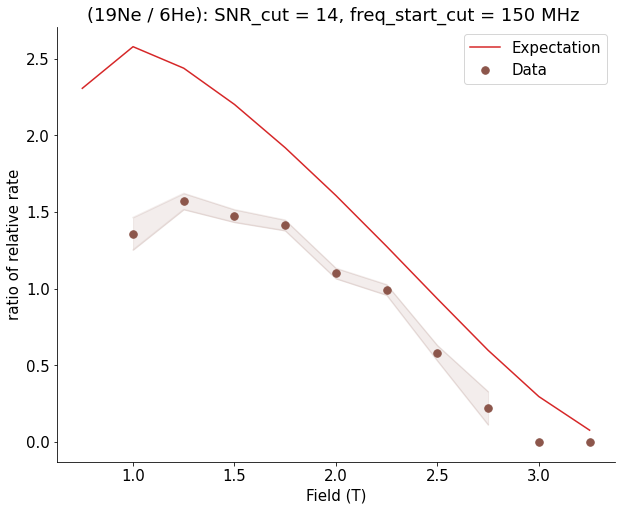

200 14


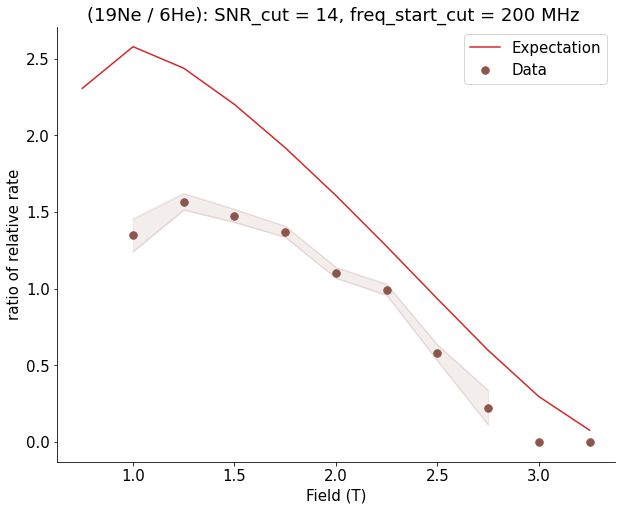

250 14


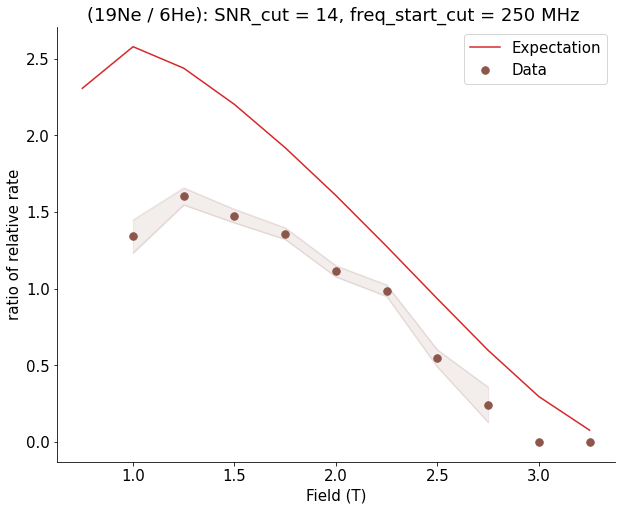

300 14


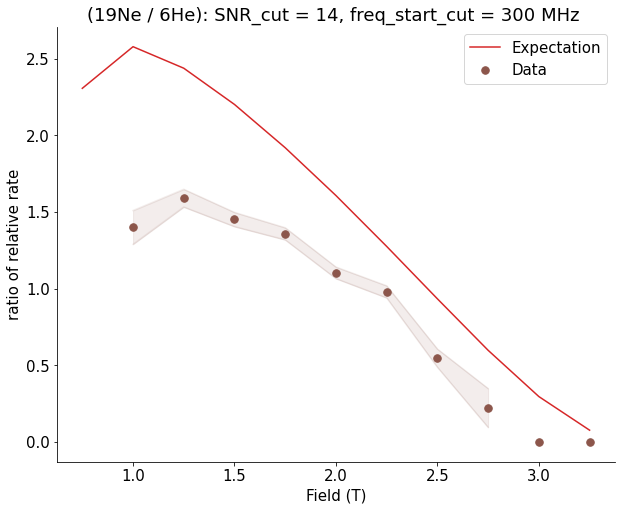

350 14


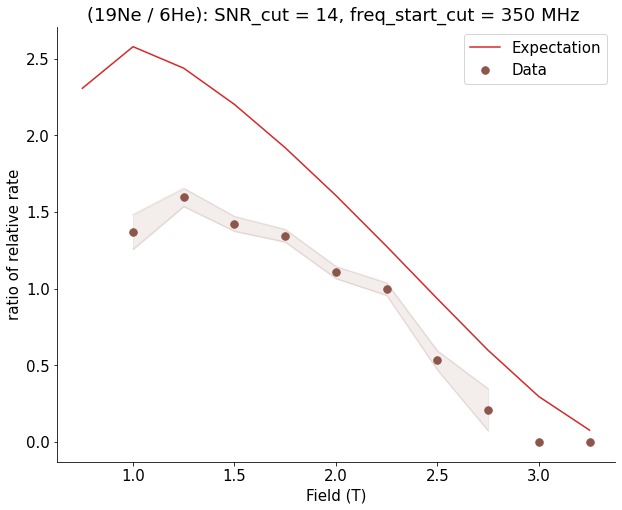

400 14


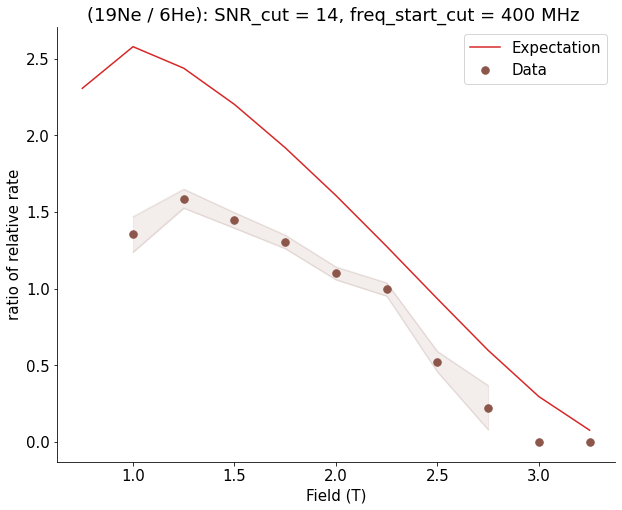

450 14


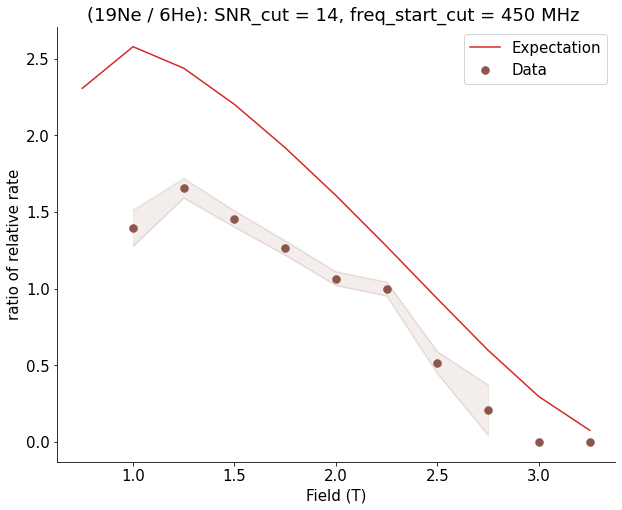

500 14


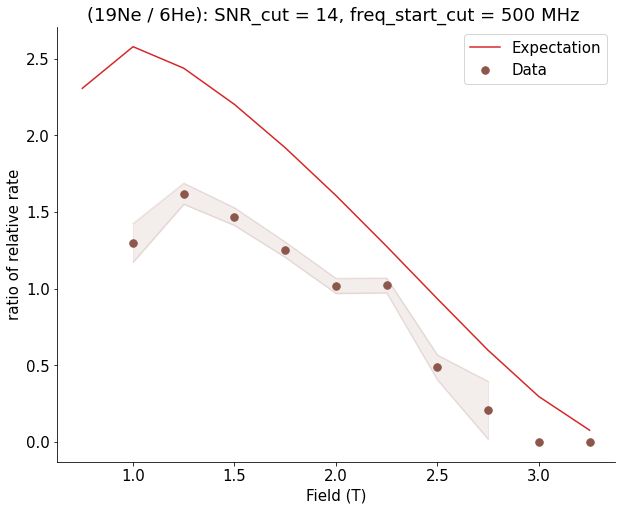

550 14


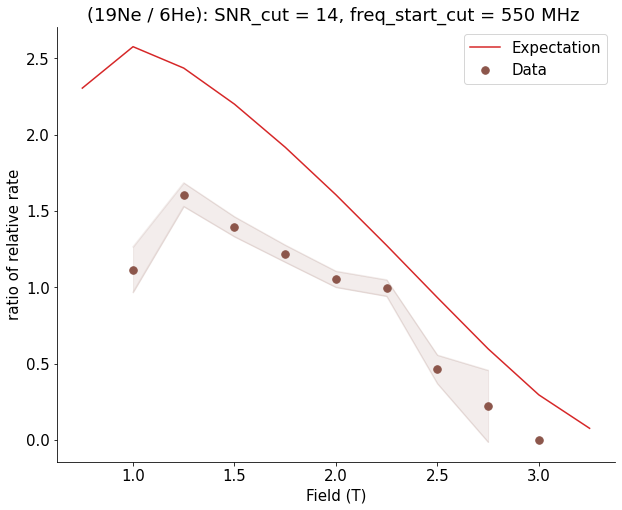

100 16


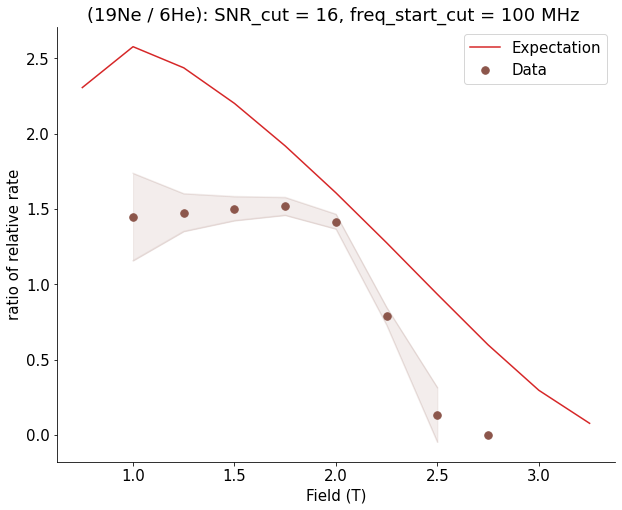

150 16


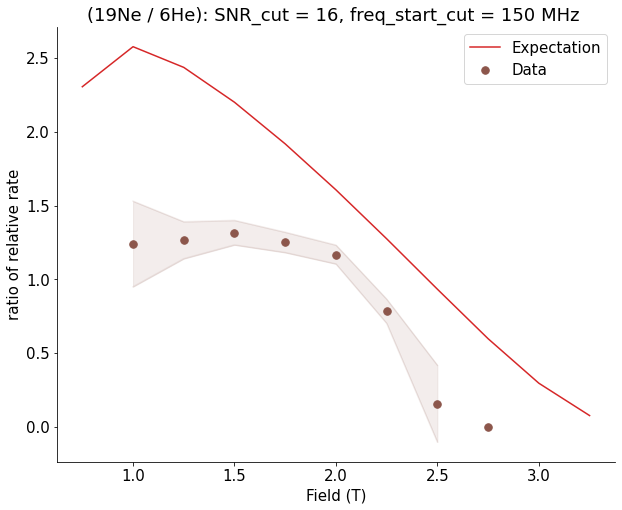

200 16


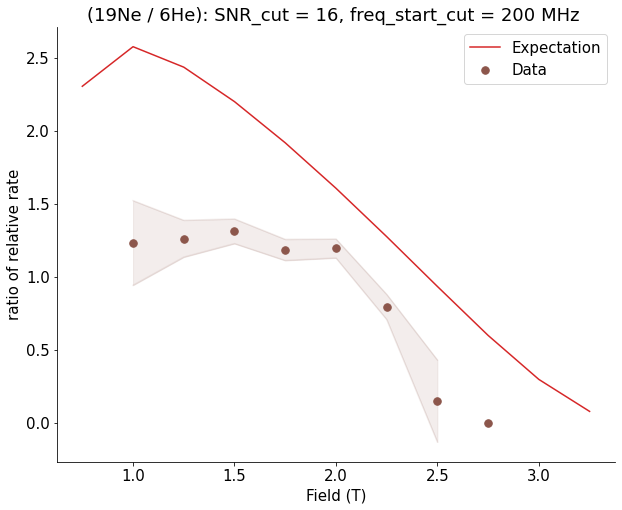

250 16


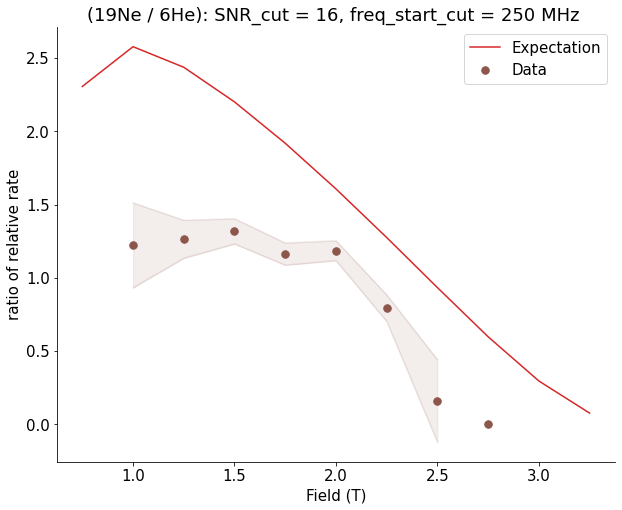

300 16


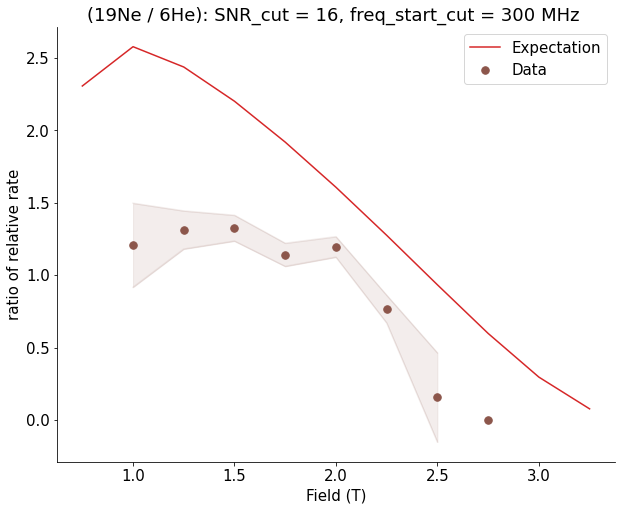

350 16


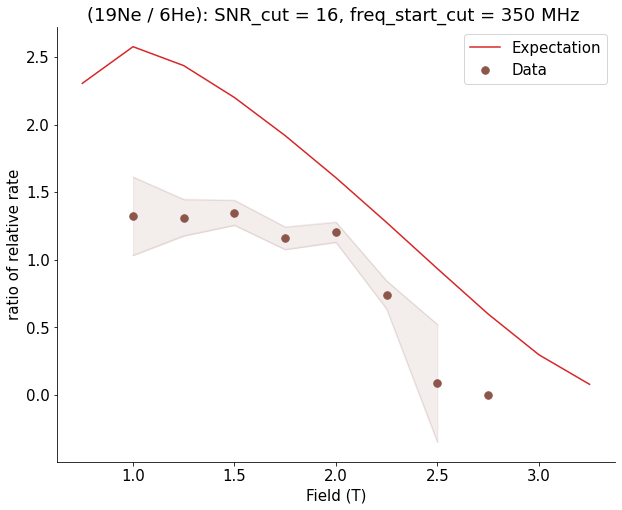

400 16


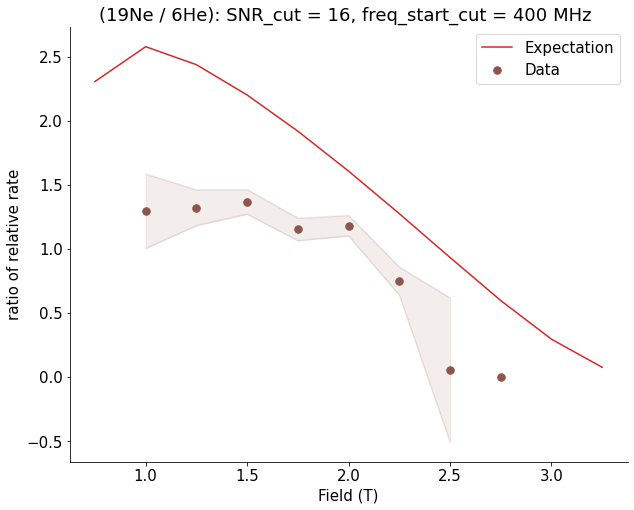

450 16


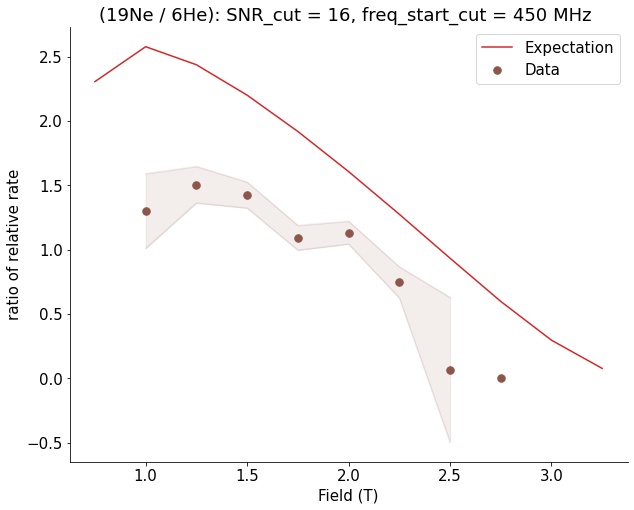

500 16


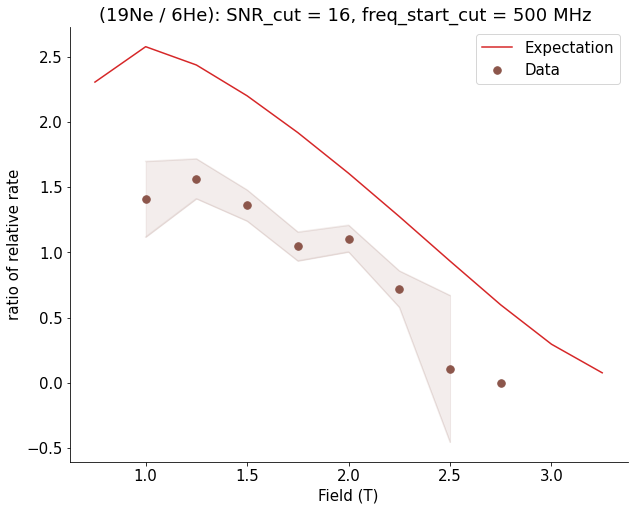

550 16


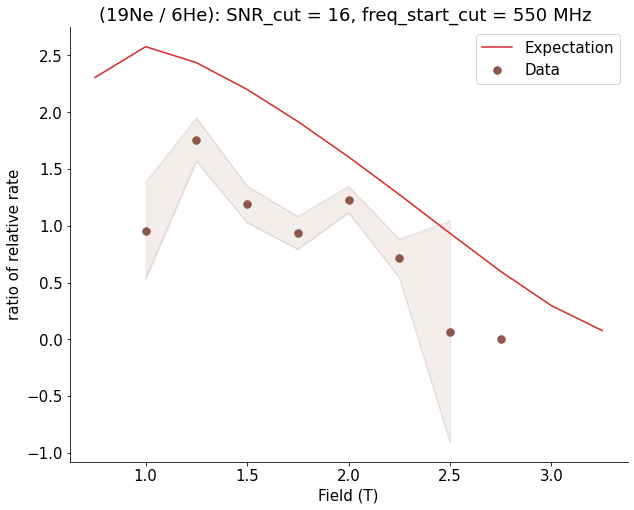

100 18


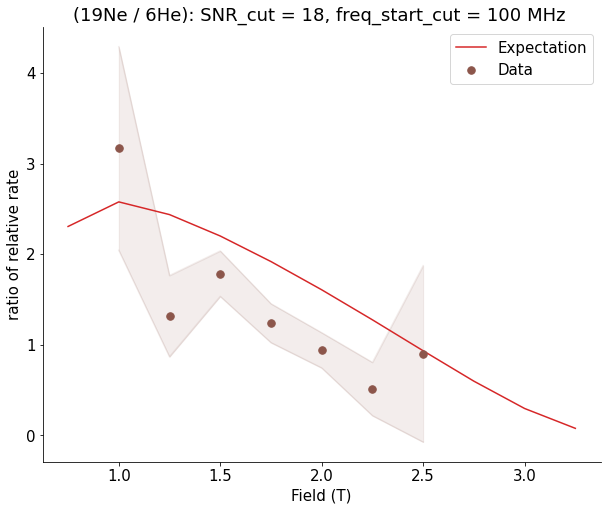

150 18


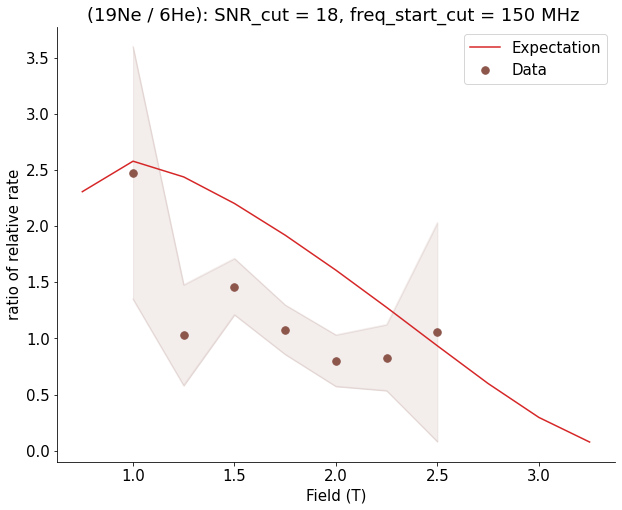

200 18


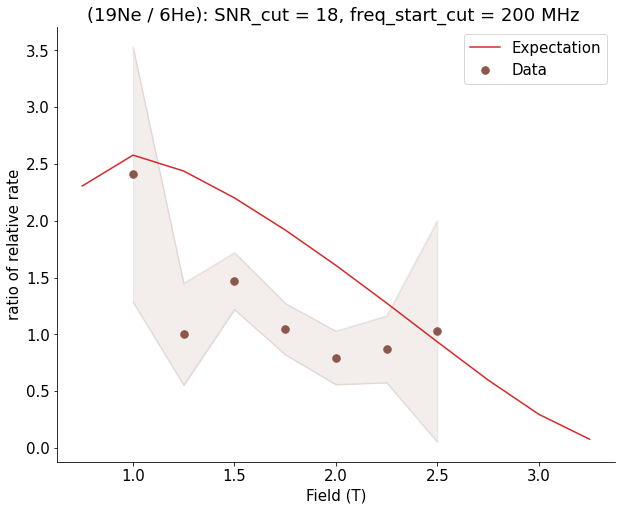

250 18


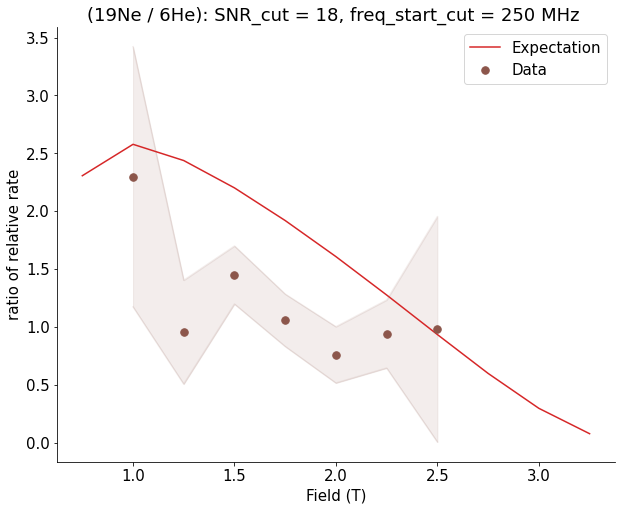

300 18


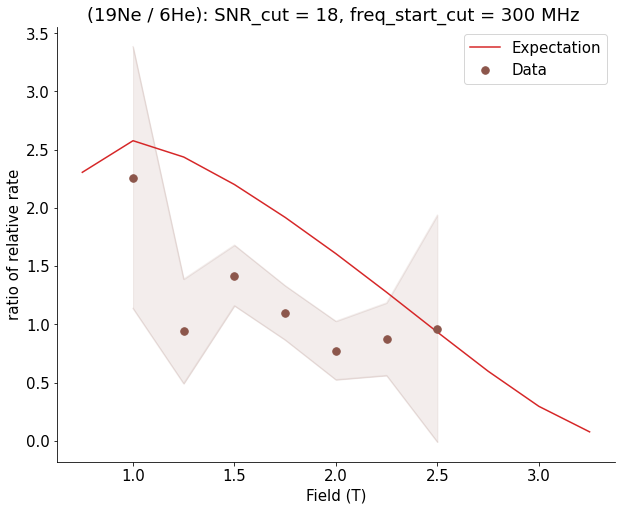

350 18


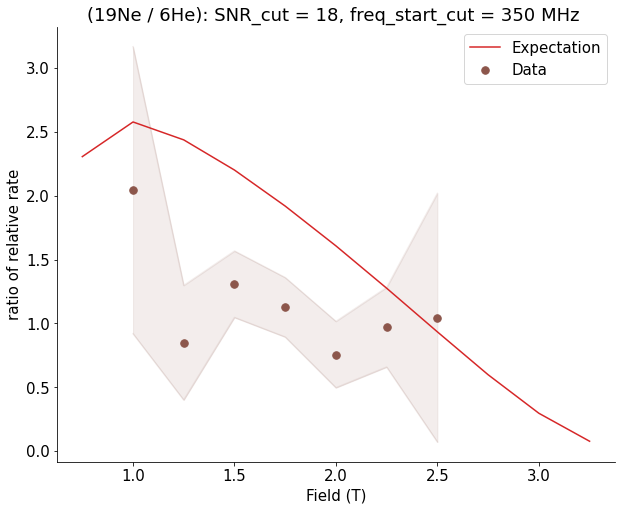

400 18


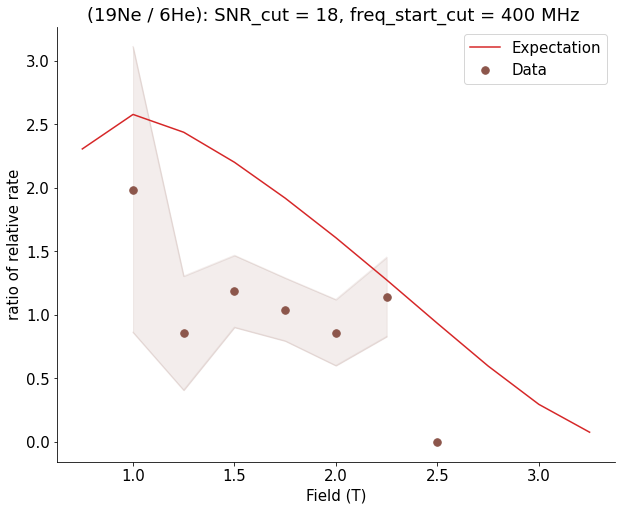

450 18


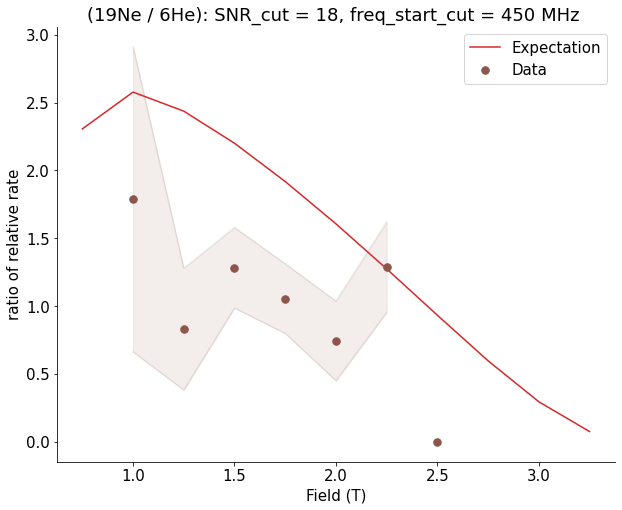

500 18


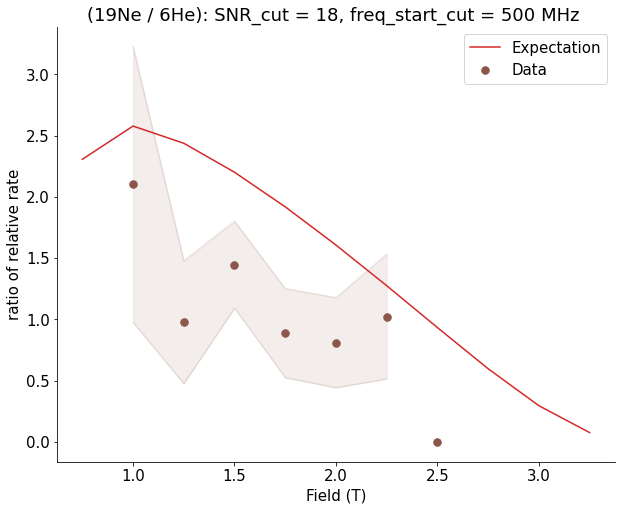

550 18


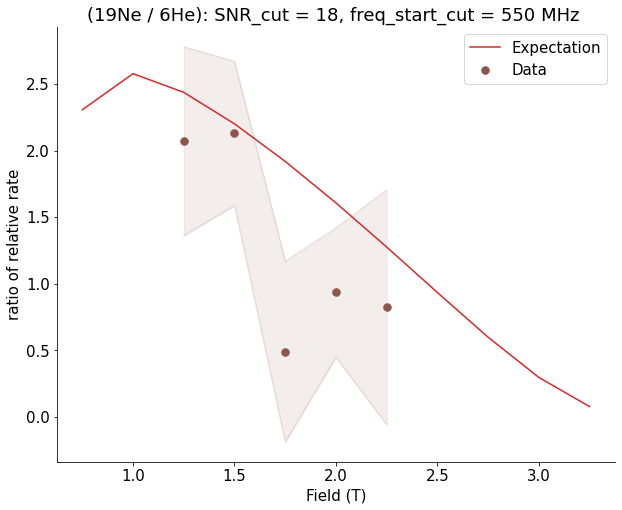

In [23]:
%matplotlib inline
plt.close("all")
plt.rcParams.update({'font.size': 15})



freq = np.arange(100, 600, 50)
snr = np.arange(10, 20, 2)

freq_cuts, snr_cuts = np.meshgrid(freq, snr)
freq_cuts = freq_cuts.flatten()
snr_cuts = snr_cuts.flatten()

for freq_cut, snr_cut in zip(freq_cuts, snr_cuts):
    
    plt.close("all")
    fig, ax = plt.subplots(figsize=(10,8))
    print(freq_cut, snr_cut)

    he_spectrum = build_spectrum(he.events, he.root_files, cuts = {"EventMeanSNR": snr_cut, "EventStartFreq": freq_cut*1e6})
    ne_spectrum = build_spectrum(ne.events, ne.root_files, cuts = {"EventMeanSNR": snr_cut, "EventStartFreq": freq_cut*1e6})

    sim_df = post_cut_sim(events_ne_sim,events_he_sim, snr_cut = .25)

    x = he_spectrum["set_field"]
    y_mean = sim_df["rate_ne"] / sim_df["rate_he"]
    y_mean_sampled = sim_df["sampled_rate_ne"] / sim_df["sampled_rate_he"]

    error = 0.5*(sim_df["rate_err_ne"]/sim_df["rate_ne"] +  sim_df["rate_err_he"]/sim_df["rate_he"]) 

    y_mean_norm = y_mean 
    error_norm = error 

    lower = y_mean_norm - error_norm
    upper = y_mean_norm + error_norm
    color = "tab:purple"


    # # Draw plot with error band and extra formatting to match seaborn style
    # ax.plot(x, y_mean_norm, label= f"Monte Carlo", color = "tab:purple")
    # ax.plot(x, lower, color=color, alpha=0.1)
    # ax.plot(x, upper, color=color, alpha=0.1)
    # ax.fill_between(x, lower, upper, alpha=0.1)

    # Plot MC with just the sampled rates: 
    ax.plot(x, y_mean_sampled, label= f"Expectation", color = "tab:red")


    x = he_spectrum["set_field"]
    y_mean = ne_spectrum["mon_adjusted_count"] / he_spectrum["mon_adjusted_count"] / (ne_spectrum["mon_adjusted_count"].mean() / he_spectrum["mon_adjusted_count"].mean())

    error = 0.5*(ne_spectrum["mon_adjusted_count_uncert"]/ne_spectrum["mon_adjusted_count"] +  ne_spectrum["mon_adjusted_count_uncert"]/ne_spectrum["mon_adjusted_count"]) 

    y_mean_norm = y_mean 
    error_norm = error 

    lower = y_mean_norm - error_norm
    upper = y_mean_norm + error_norm
    color = "tab:brown"

    # Draw plot with error band and extra formatting to match seaborn style
    ax.plot(x, y_mean_norm, label= f"Data", color = color, ls='', marker='.', markersize = 15)
    ax.plot(x, lower, color=color, alpha=0.1)
    ax.plot(x, upper, color=color, alpha=0.1)
    ax.fill_between(x, lower, upper,color=color, alpha=0.1)
    ax.set_xlabel('Field (T)')

    ax.set_ylabel('ratio of relative rate')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f"(19Ne / 6He): SNR_cut = {snr_cut:.0f}, freq_start_cut = {freq_cut:.0f} MHz ")

    ax.legend() 
    # ax.set_yscale('log')
    base_path = "/media/drew/T7 Shield/rocks_analysis/paper_02_figures/ratio_cuts_12152022"
    dir_path = Path(base_path) / Path(f"freq_snr__{freq_cut:.0f}_{snr_cut:.0f}")
    fig_path = dir_path / Path(f"ratio__freq_snr__{freq_cut:.0f}_{snr_cut:.0f}.png")
    plt.savefig(fig_path)
    plt.show()

In [103]:
he.events.columns

Index(['run_id', 'file_id', 'EventID', 'EventStartTime', 'EventEndTime',
       'EventStartFreq', 'EventEndFreq', 'EventTimeLength', 'EventFreqLength',
       'EventTrackCoverage', 'EventMeanSNR', 'EventSlope', 'EventNBins',
       'EventTrackTot', 'EventFreqIntc', 'EventTimeIntc', 'field', 'set_field',
       'monitor_rate'],
      dtype='object')

## Thoughts on the above: 


### Notes: 

* SNR = .4, freq = 300 puts the lines on top of eachother. But otherwise it's a little all over the place. How an we make the decisions around these cuts more quantitative? 

### Questions: 

* Why does the ratio differ before and after a cut in simulation? The distribution of higher power events is different? Shouldn't that not be the case? Maybe look at the overlaid power histograms (like you did for real data). 
* Right now the way I apply a cut in SNR is relative to the maximum power in that df (isotope). This means that since they have different noise floors and SNRs this cut isn't corresponding to the same power for both of them? Could this be causing the issue. What if I just cut at an absolute SNR instead? I changed it to an absolute number and that may be helping? Hmm or maybe it should really be a cut in total track power. 
* I need to investigate the effects of cuts on the ratio just in MC. This would shed light on these issues. 
* 

### Notes from 12/15/22: 

* Goal is to make a grid of cuts in start freq and SNR and also make corresponding histograms for length, start freq. 
    * Starting with ratio plots. 
    
* Another cut to make: cut tracks that start at t = 0! (come in from the side. 

<AxesSubplot:title={'center':'Preliminary Ratio (19Ne / 6He)'}, xlabel='Field (T)', ylabel='Frequency'>

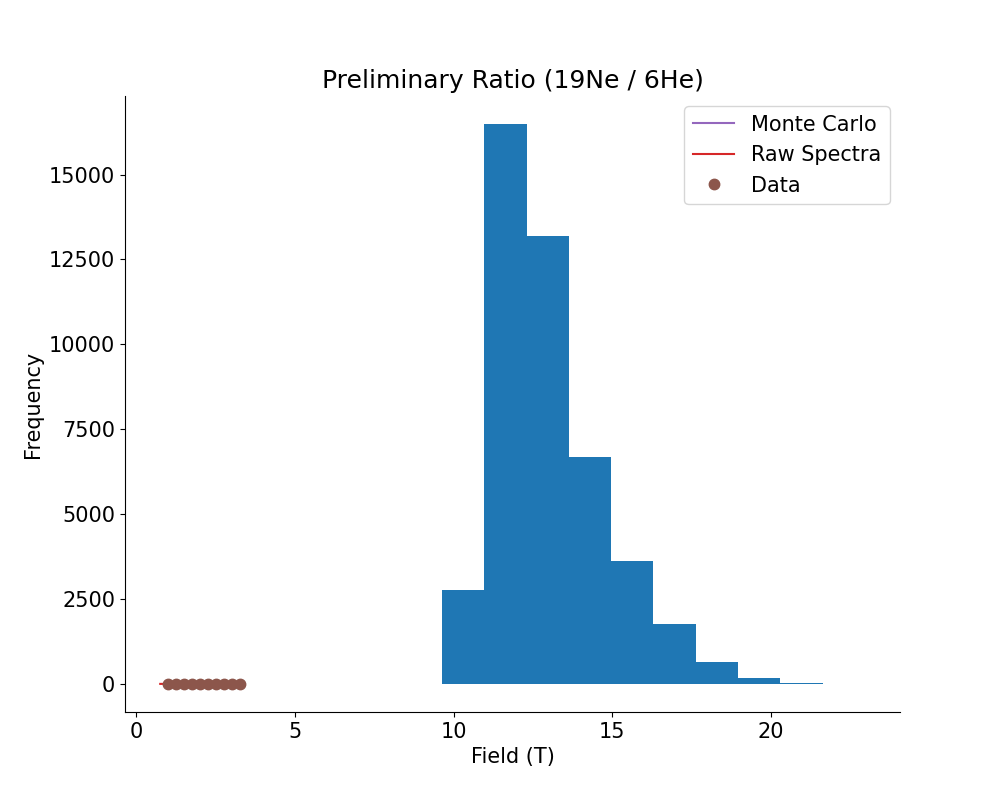

In [81]:
he_spectrum = build_spectrum(he.events, he.root_files, cuts = {"EventMeanSNR": EventMeanSNR, "EventStartFreq": EventStartFreq*1e6})
he.events.EventMeanSNR.plot.hist()

## Building plot with the raio's sensitivity to the different cuts. 

* NOte from the above histogram. This means that changes in SNR are only relavant between .5 - 1

In [ ]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.close("all")
# print("\nHe:\n")
fig, ax = plt.subplots(figsize=(15,8))

EventStartFreq = 175 

for EventMeanSNR in np.arange(.45,.75,.05): 
    print(EventMeanSNR) 
    he_spectrum = build_spectrum(he.events, he.root_files, cuts = {"EventMeanSNR": EventMeanSNR, "EventStartFreq": EventStartFreq*1e6})
    ne_spectrum = build_spectrum(ne.events, ne.root_files, cuts = {"EventMeanSNR": EventMeanSNR, "EventStartFreq": EventStartFreq*1e6})

    x = he_spectrum["set_field"]
    y_mean = ne_spectrum["mon_adjusted_count"] / he_spectrum["mon_adjusted_count"] / (ne_spectrum["mon_adjusted_count"].mean() / he_spectrum["mon_adjusted_count"].mean())

    error = 0.5*(ne_spectrum["mon_adjusted_count_uncert"]/ne_spectrum["mon_adjusted_count"] +  ne_spectrum["mon_adjusted_count_uncert"]/ne_spectrum["mon_adjusted_count"]) 
 
    y_mean_norm = y_mean 
    error_norm = error 

    lower = y_mean_norm - error_norm
    upper = y_mean_norm + error_norm
    color = np.random.rand(3,)
    # Draw plot with error band and extra formatting to match seaborn style
    ax.plot(x, y_mean_norm, label= f"SNR_cut: {EventMeanSNR:.2f}", color = color)
    ax.plot(x, lower, color=color, alpha=0.1)
    ax.plot(x, upper, color=color, alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.1)
    ax.set_xlabel('set_field')

    ax.set_ylabel('ratio of relative rates')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("Ratio (Ne/He). Varying SNR cut.")
    
ax.legend()
# ax.set_yscale('log')
plt.show()


In [ ]:
%matplotlib widget
plt.rcParams.update({'font.size': 15})
plt.close("all")
# print("\nHe:\n")
fig, ax = plt.subplots(figsize=(15,8))

EventMeanSNR = .4

for EventStartFreq in np.arange(150, 1000, 100): 
    # print(EventStartFreq) 
    he_spectrum = build_spectrum(he.events, he.root_files, cuts = {"EventMeanSNR": EventMeanSNR, "EventStartFreq": EventStartFreq*1e6})
    ne_spectrum = build_spectrum(ne.events, ne.root_files, cuts = {"EventMeanSNR": EventMeanSNR, "EventStartFreq": EventStartFreq*1e6})

    x = he_spectrum["set_field"]
    y_mean = ne_spectrum["mon_adjusted_count"] / he_spectrum["mon_adjusted_count"] 

    error = 0.5*(ne_spectrum["mon_adjusted_count_uncert"]/ne_spectrum["mon_adjusted_count"] +  ne_spectrum["mon_adjusted_count_uncert"]/ne_spectrum["mon_adjusted_count"]) 
 
    y_mean_norm = y_mean 
    error_norm = error 

    lower = y_mean_norm - error_norm
    upper = y_mean_norm + error_norm
    color = np.random.rand(3,)
    # Draw plot with error band and extra formatting to match seaborn style
    ax.plot(x, y_mean_norm, label= f"Freq. Cut: {EventStartFreq:.0f} MHz", color = color)
    ax.plot(x, lower, color=color, alpha=0.1)
    ax.plot(x, upper, color=color, alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.1)
    ax.set_xlabel('Field (T)')

    ax.set_ylabel('ratio of relative rate')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("Ratio (19Ne / 6He). Varying Event Start Freq. Cut")
    # print("Tot ne counts: {}".format(ne_spectrum["mon_adjusted_count"].sum()))
    # print("Tot he counts: {}\n".format(he_spectrum["mon_adjusted_count"].sum()))
ax.legend(loc = "upper right")
# ax.set_yscale('log')
plt.show()


In [57]:
ne.root_files.groupby(["set_field"])[["root_file_exists", "monitor_rate"]].sum().reset_index()

,set_field,root_file_exists,monitor_rate
0,0.75,500,5727615.45
1,1.00,699,6999175.43
2,1.25,498,5589774.18
3,1.50,497,4899456.25
4,1.75,498,5117546.79
5,2.00,496,5274760.77
6,2.25,496,5427799.02
7,2.50,500,5243144.62
8,2.75,498,5515606.63
9,3.00,500,5826929.03


In [57]:
ne.root_files.groupby(["set_field"])[["root_file_exists", "monitor_rate"]].sum().reset_index()

,set_field,root_file_exists,monitor_rate
0,0.75,500,5727615.45
1,1.00,699,6999175.43
2,1.25,498,5589774.18
3,1.50,497,4899456.25
4,1.75,498,5117546.79
5,2.00,496,5274760.77
6,2.25,496,5427799.02
7,2.50,500,5243144.62
8,2.75,498,5515606.63
9,3.00,500,5826929.03
